# Ingest and View Data

In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
POSTGRES_USERNAME = 'root'
POSTGRES_PASSWORD = 'koBREipm4h7CuRKix2Tn'
POSTGRES_HOSTNAME = 'database-1.c3ma8u2guxxs.us-east-2.rds.amazonaws.com'
POSTGRES_PORT = '5432'
POSTGRES_DBNAME = 'postgres'

connection_string = f"postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_HOSTNAME}:{POSTGRES_PORT}/{POSTGRES_DBNAME}"
engine = create_engine(connection_string)

In [3]:
query = """
SELECT * FROM darwin
"""

df = pd.read_sql(query, engine)

In [4]:
df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_pass,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,...,platform,train_length,estimated_time,source,actual_time,actual_time_class,is_delayed_arrival,is_delayed_departure,source_instance,estimated_time_minutes
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,None,19:31:00,19:31:30,19:31:00,19:31:00,...,4,10.0,None,None,None,None,False,False,None,None
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,None,19:37:00,19:38:00,19:37:00,19:38:00,...,A,NaN,None,None,None,None,False,False,None,None
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,None,19:30:30,19:31:00,19:31:00,19:31:00,...,2,NaN,None,None,None,None,False,False,None,None
3,202407036735756,C35756,2024-07-03,TD,BRMB,None,19:33:00,19:33:30,19:33:00,19:33:00,...,1,NaN,None,None,None,None,False,False,None,None
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,None,19:35:00,19:35:30,19:35:00,19:35:00,...,2,NaN,None,None,None,None,False,False,None,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120541 entries, 0 to 120540
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   route_id                120541 non-null  object 
 1   unique_id               120541 non-null  object 
 2   service_start_date      120541 non-null  object 
 3   update_origin           117671 non-null  object 
 4   train_platform          120541 non-null  object 
 5   working_time_pass       0 non-null       object 
 6   working_time_arrival    120541 non-null  object 
 7   working_time_departure  120541 non-null  object 
 8   planned_time_arrival    111792 non-null  object 
 9   planned_time_departure  111418 non-null  object 
 10  actual_arrival_time     102946 non-null  object 
 11  actual_departure_time   113017 non-null  object 
 12  platform                113571 non-null  object 
 13  train_length            39565 non-null   float64
 14  estimated_time      

# Clean DF 
**Drop Null Columns and Unnecessary Columns**

In [6]:
# columns to drop due to null values
columns_to_drop = [
    'working_time_pass',
    'estimated_time',
    'source',
    'actual_time',
    'actual_time_class',
    'source_instance',
    'estimated_time_minutes',
    'train_length'            
]

df_cleaned = df.drop(columns=columns_to_drop)

In [7]:
# check duplicates
duplicates = df_cleaned.duplicated().sum()
duplicates

5272

In [8]:
# to drop duplicates
# df_clean = df_clean.drop_duplicates()

In [9]:
# check nulls
df_cleaned.isna().sum()

route_id                      0
unique_id                     0
service_start_date            0
update_origin              2870
train_platform                0
working_time_arrival          0
working_time_departure        0
planned_time_arrival       8749
planned_time_departure     9123
actual_arrival_time       17595
actual_departure_time      7524
platform                   6970
is_delayed_arrival            0
is_delayed_departure          0
dtype: int64

In [10]:
# to drop remaining nulls
# df_cleaned = df_cleaned.dropna()

# Create Delay DF

In [11]:
query_delay = "SELECT * FROM darwin WHERE is_delayed_arrival = True AND is_delayed_departure = True"
df_delay = pd.read_sql(query_delay, engine)

In [12]:
df_delay = df_delay.drop(columns=columns_to_drop)

In [13]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10905 entries, 0 to 10904
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   route_id                10905 non-null  object
 1   unique_id               10905 non-null  object
 2   service_start_date      10905 non-null  object
 3   update_origin           10895 non-null  object
 4   train_platform          10905 non-null  object
 5   working_time_arrival    10905 non-null  object
 6   working_time_departure  10905 non-null  object
 7   planned_time_arrival    5965 non-null   object
 8   planned_time_departure  5944 non-null   object
 9   actual_arrival_time     10897 non-null  object
 10  actual_departure_time   10876 non-null  object
 11  platform                8035 non-null   object
 12  is_delayed_arrival      10905 non-null  bool  
 13  is_delayed_departure    10905 non-null  bool  
dtypes: bool(2), object(12)
memory usage: 1.0+ MB


In [14]:
df_delay.duplicated().sum()

58

# Adding Duration Column
Convert times from object datatypes to time datatypes.

In [15]:
df_cleaned['working_time_arrival'] = pd.to_datetime(df_cleaned['working_time_arrival'], format='%H:%M:%S')
df_cleaned['working_time_departure'] = pd.to_datetime(df_cleaned['working_time_departure'], format='%H:%M:%S')

Complete math to find duration.

In [16]:
df_cleaned['duration (min)'] = ((df_cleaned['working_time_departure']-df_cleaned['working_time_arrival'])\
                                .dt.total_seconds()/60)

Transition back to time only.

In [17]:
df_cleaned['working_time_arrival'] = df_cleaned['working_time_arrival'].dt.time
df_cleaned['working_time_departure'] = df_cleaned['working_time_departure'].dt.time

Repeat for Delay Dataframe.

In [18]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time

In [19]:
# Check for zero and negative values
neg_zero_duration_counts = df_cleaned[df_cleaned['duration (min)'] <= 0]['duration (min)'].value_counts().sort_index(ascending=True)

# Display the result
print(neg_zero_duration_counts)

duration (min)
-1438.5       4
-1438.0       8
-1437.5       2
-1437.0       7
-1436.0      16
-1435.0       9
-1434.0       5
-1433.0       3
-1432.0       3
-1430.0      22
-1427.0       2
-1420.0       1
-1419.0       3
-1418.0       3
-1406.5       1
-1401.0       4
-1313.5       2
-1310.5       1
 0.0       1096
Name: count, dtype: int64


In [20]:
# Drop the rows with negative values in duration
df_cleaned = df_cleaned[df_cleaned['duration (min)'] > 0]

In [21]:
# Check
neg_zero_duration_counts = df_cleaned[df_cleaned['duration (min)'] <= 0]['duration (min)'].value_counts().sort_index(ascending=True)

# Display the result
print(neg_zero_duration_counts)

Series([], Name: count, dtype: int64)


# Ingest Rail References Data

In [22]:
reference_df = pd.read_csv('./raw_data/RailReferences.csv')

## Convert Easting, Northing to Latitude and Longitude

In [23]:
!pip install pyproj

In [24]:
from pyproj import Transformer

In [25]:
#  Define the British National Grid projection (EPSG:27700) and WGS84
osgb_projection = 'epsg:27700'  # British National Grid
wgs84_projection = 'epsg:4326'  # WGS84

In [26]:
# Initialize the transformer
transformer = Transformer.from_crs(osgb_projection, wgs84_projection)

In [27]:
# Function to convert British National Grid to latitude and longitude
def convert_osgb_to_latlong(easting, northing):
    longitude, latitude = transformer.transform(easting, northing)
    return longitude, latitude

In [28]:
# Apply conversion to the DataFrame and create new columns Latitude and Longitude
reference_df[['Latitude', 'Longitude']] = reference_df.apply(lambda row: convert_osgb_to_latlong(row['Easting'], row['Northing']),\
                                         axis=1,\
                                         result_type='expand')

In [29]:
# Data need for analysis 
data = reference_df[['TiplocCode', 'StationName', 'Latitude', 'Longitude']]
data

,TiplocCode,StationName,Latitude,Longitude
0,PENZNCE,Penzance Rail Station,50.121672,-5.532565
1,STIVES,St Ives (Cornwall) Rail Station,50.209043,-5.477912
2,CARBISB,Carbis Bay Rail Station,50.197048,-5.463263
3,STERTH,St Erth Rail Station,50.170489,-5.444252
4,LELANTS,Lelant Saltings Rail Station,50.178775,-5.440926
...,...,...,...,...
2623,SMRLYTN,Somerleyton Rail Station,52.510229,1.652260
2624,OULTNBS,Oulton Broad South Rail Station,52.469602,1.707659
2625,YARMTH,Great Yarmouth Rail Station,52.612158,1.720886
2626,OULTNBN,Oulton Broad North Rail Station,52.477759,1.715711


### Data Enrichment
Used this section to add identifying information for top Timing Point Locations (*TiplocCode*) not already identified in the supplied "RailReferences.csv" data. 

Research indicates that the Timing Point Location for BONDST, correlates to Bond Street Station$^{1}$ located at 51.514°N, 0.15°W$^{2}$. 

In [30]:
new_row = pd.DataFrame([['BONDST', 'Bond Street Station', 51.514, -0.15]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for TOTCTRD, correlates to Tottenham Court Road$^{1}$ located at 51.5207°N, 0.1345°W$^{3}$. 

In [31]:
new_row = pd.DataFrame([['TOTCTRD', 'Tottenham Court Road', 51.5207, -0.1345]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for CANWHRF, correlates to Canary Wharf Railway Station$^{1}$ located at 51.5061°N, 0.01578°W$^{4}$. 

In [32]:
new_row = pd.DataFrame([['CANWHRF', 'Canary Wharf Railway Station', 51.5061, -0.01578]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for WCHAPXR, correlates to Whitechapel Crossrail$^{1}$ located at 51.5195°N, 0.0612°W$^{5, 6}$. 

In [33]:
new_row = pd.DataFrame([['WCHAPXR', 'Whitechapel Crossrail', 51.9195, -0.0612]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for LIVSTLL, correlates to London Liverpool Street Crossrail$^{1}$ located at 51.5186°N, 0.0813°W$^{6, 7}$. 

In [34]:
new_row = pd.DataFrame([['LIVSTLL', 'London Liverpool Street Crossrail', 51.5186, -0.0813]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

### Bibliography

1. http://www.railwaycodes.org.uk/crs/crsb.shtm

2. https://en.wikipedia.org/wiki/Bond_Street_station

3. https://en.wikipedia.org/wiki/Tottenham_Court_Road

4. https://en.wikipedia.org/wiki/Canary_Wharf_railway_station

5. https://en.wikipedia.org/wiki/Whitechapel_station

6. https://en.wikipedia.org/wiki/Crossrail

7. https://en.wikipedia.org/wiki/Liverpool_Street_station

## Using Rail References to Replace Train Platform with Station Name

In [35]:
# Merge df_cleaned with data columns from reference_df

df_merged = df_cleaned.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [36]:
# checking where train_platform has no related StationName/Tiploccode
nan_rows = df_merged[df_merged[['TiplocCode', 'StationName']].isna().any(axis=1)]

nan_rows[['train_platform', 'TiplocCode', 'StationName']]

,train_platform,TiplocCode,StationName
16,WOLWXR,NaN,NaN
23,FRMPKRS,NaN,NaN
24,HRNS451,NaN,NaN
25,BOWERRL,NaN,NaN
52,CMRNBDG,NaN,NaN
...,...,...,...
119077,STALBCS,NaN,NaN
119092,FRNDXR,NaN,NaN
119175,MAGHNTH,NaN,NaN
119243,CNNBELL,NaN,NaN


In [37]:
# Identifying most highly frequented unknown Station Names
station_NaN = df_merged[df_merged['StationName'].isna()]['train_platform'].value_counts()
station_NaN.head(20)

train_platform
FRNDXR     377
CUSTMHS    226
PADTLL     215
WOLWXR     214
BRENTX     165
STALBCS    132
MAGHNTH    120
CNNBELL     86
MLLF        75
PALL        74
STDI        72
LTCEREC     69
FELL        69
LTCEADL     68
UNIV        68
BOWERRL     67
CIVI        66
PELAWTW     58
EBSFLTI     55
HEWOMTR     51
Name: count, dtype: int64

In [38]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_merged['StationName'] = df_merged['StationName'].fillna(df_merged['train_platform'])

# Drop TiplocCode to avoid redundency
# df_merged.drop(columns=['TiplocCode'], inplace=True)

# Replace 'Rail Station' with an empty string to make more readable
df_merged['StationName'] = df_merged['StationName'].str.replace(' Rail Station', '')

In [39]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119349 entries, 0 to 119348
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   route_id                119349 non-null  object 
 1   unique_id               119349 non-null  object 
 2   service_start_date      119349 non-null  object 
 3   update_origin           116489 non-null  object 
 4   train_platform          119349 non-null  object 
 5   working_time_arrival    119349 non-null  object 
 6   working_time_departure  119349 non-null  object 
 7   planned_time_arrival    111346 non-null  object 
 8   planned_time_departure  110978 non-null  object 
 9   actual_arrival_time     101912 non-null  object 
 10  actual_departure_time   111878 non-null  object 
 11  platform                113025 non-null  object 
 12  is_delayed_arrival      119349 non-null  bool   
 13  is_delayed_departure    119349 non-null  bool   
 14  duration (min)      

# Delays

In [40]:
df_delay = df_delay.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [41]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_delay['StationName'] = df_delay['StationName'].fillna(df_delay['train_platform'])

# Replace 'Rail Station' with an empty string to make more readable
df_delay['StationName'] = df_delay['StationName'].str.replace(' Rail Station', '')

In [42]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10905 entries, 0 to 10904
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                10905 non-null  object 
 1   unique_id               10905 non-null  object 
 2   service_start_date      10905 non-null  object 
 3   update_origin           10895 non-null  object 
 4   train_platform          10905 non-null  object 
 5   working_time_arrival    10905 non-null  object 
 6   working_time_departure  10905 non-null  object 
 7   planned_time_arrival    5965 non-null   object 
 8   planned_time_departure  5944 non-null   object 
 9   actual_arrival_time     10897 non-null  object 
 10  actual_departure_time   10876 non-null  object 
 11  platform                8035 non-null   object 
 12  is_delayed_arrival      10905 non-null  bool   
 13  is_delayed_departure    10905 non-null  bool   
 14  duration (min)          10905 non-null

Determine the minutes delayed.

In [43]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)

In [44]:
df_delay['actual_arrival_time'] = pd.to_datetime(df_delay['actual_arrival_time'], format='%H:%M:%S')
df_delay['actual_departure_time'] = pd.to_datetime(df_delay['actual_departure_time'], format='%H:%M:%S')

In [45]:
df_delay['depart_delay(min)'] = ((df_delay['actual_departure_time']-df_delay['working_time_departure'])\
                                .dt.total_seconds()/60)

In [46]:
df_delay['arrive_delay(min)'] = ((df_delay['actual_arrival_time']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)

In [47]:
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time
df_delay['actual_arrival_time'] = df_delay['actual_arrival_time'].dt.time
df_delay['actual_departure_time'] = df_delay['actual_departure_time'].dt.time

In [48]:
df_delay.describe()

,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,10905.000000,8254.000000,8254.000000,10876.000000,10897.000000
mean,-2.627442,52.520067,-1.248337,-27.561944,-30.231894
std,91.292964,1.425111,1.402030,310.912789,322.389276
min,-1438.000000,50.170489,-5.444252,-1435.000000,-1437.000000
25%,0.500000,51.532026,-2.255592,5.000000,6.000000
50%,1.000000,51.746909,-0.676651,24.000000,26.000000
75%,3.000000,53.497484,-0.170265,67.500000,69.500000
max,247.000000,57.188510,1.707659,1320.500000,1438.000000


We can see that the math in the previous step created some erroneous values (minimum of depart_delay(min) is negative.) This will occur in cases where there is no reported actual_departure_time. We will get the value zero where the train is not delayed. We will define a function to remove delays less than or equal to zero.

In [49]:
def remove_neg_and_zero(delay):
    if delay <= 0:
        delay = None
    else:
        delay = delay
    return delay

In [50]:
df_delay['depart_delay(min)'] = df_delay['depart_delay(min)'].apply(remove_neg_and_zero)
df_delay['arrive_delay(min)'] = df_delay['arrive_delay(min)'].apply(remove_neg_and_zero)

In [51]:
df_delay.describe()

,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,10905.000000,8254.000000,8254.000000,9260.000000,9770.000000
mean,-2.627442,52.520067,-1.248337,48.907268,48.662697
std,91.292964,1.425111,1.402030,50.831094,54.875402
min,-1438.000000,50.170489,-5.444252,0.500000,0.500000
25%,0.500000,51.532026,-2.255592,10.000000,9.500000
50%,1.000000,51.746909,-0.676651,36.000000,35.000000
75%,3.000000,53.497484,-0.170265,74.000000,74.000000
max,247.000000,57.188510,1.707659,1320.500000,1438.000000


We can see that the are some erroneous high values for depart_delay(min) and arrive_delay(min). We will remove any values over 420minutes (7hrs), assuming those trains are rescheduled rather than delayed.

In [52]:
def remove_over_420(delay):
    if delay > 420:
        delay = None
    else:
        delay = delay
    return delay

In [53]:
df_delay['depart_delay(min)'] = df_delay['depart_delay(min)'].apply(remove_over_420)
df_delay['arrive_delay(min)'] = df_delay['arrive_delay(min)'].apply(remove_over_420)

In [54]:
df_delay.describe()

,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,10905.000000,8254.000000,8254.000000,9257.000000,9765.000000
mean,-2.627442,52.520067,-1.248337,48.497386,47.990891
std,91.292964,1.425111,1.402030,45.453289,46.146019
min,-1438.000000,50.170489,-5.444252,0.500000,0.500000
25%,0.500000,51.532026,-2.255592,10.000000,9.500000
50%,1.000000,51.746909,-0.676651,36.000000,34.500000
75%,3.000000,53.497484,-0.170265,74.000000,74.000000
max,247.000000,57.188510,1.707659,257.500000,257.000000


In [55]:
# export delay routes csv
df_delay.to_csv('./cleaned_data/delay_durations.csv', index=False, mode = 'w+')

## Calculate Delay Duration
Take the data where we are able to calucate delays.

In [56]:
df_delay.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude,depart_delay(min),arrive_delay(min)
0,202407037144581,G44581,2024-07-03,Darwin,GLOSTER,19:22:00,19:28:00,19:21:00,19:28:00,19:32:00,...,1,True,True,6.0,GLOSTER,Gloucester,51.865557,-2.238488,5.0,10.0
1,202407036707715,C07715,2024-07-03,Darwin,LADYBHL,19:24:00,19:35:30,None,None,19:33:00,...,None,True,True,11.5,NaN,LADYBHL,NaN,NaN,NaN,9.0
2,202407037154103,G54103,2024-07-03,Darwin,CRAWLEY,19:26:30,19:27:30,19:27:00,19:27:00,19:35:00,...,2,True,True,1.0,CRAWLEY,Crawley,51.112212,-0.186673,7.5,8.5
3,202407037154103,G54103,2024-07-03,Darwin,IFIELD,19:29:30,19:30:00,19:30:00,19:30:00,19:37:00,...,2,True,True,0.5,IFIELD,Ifield,51.115621,-0.214772,8.0,7.5
4,202407037154103,G54103,2024-07-03,Darwin,FAYGATE,19:33:30,19:34:00,19:34:00,19:34:00,19:41:00,...,2,True,True,0.5,FAYGATE,Faygate,51.095889,-0.263019,8.0,7.5


In [57]:
# Create the 'delayed' column
df_merged['delayed'] = df_merged['is_delayed_arrival'] | df_merged['is_delayed_departure']

# Check
df_merged.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude,delayed
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,19:31:00,19:31:30,19:31:00,19:31:00,None,19:32:00,4,False,False,0.5,SCROYDN,South Croydon,51.362963,-0.093457,False
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,19:37:00,19:38:00,19:37:00,19:38:00,19:37:00,19:38:00,A,False,False,1.0,LIVSTLL,London Liverpool Street Crossrail,51.518600,-0.081300,False
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,19:30:30,19:31:00,19:31:00,19:31:00,None,None,2,False,False,0.5,ESTHRAK,Eastham Rake,53.307537,-2.981132,False
3,202407036735756,C35756,2024-07-03,TD,BRMB,19:33:00,19:33:30,19:33:00,19:33:00,19:33:00,19:33:00,1,False,False,0.5,BRMB,Bromborough,53.321845,-2.986895,False
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,19:35:00,19:35:30,19:35:00,19:35:00,19:35:00,19:35:00,2,False,False,0.5,BRMBRK,Bromborough Rake,53.329905,-2.989469,False


## Delays  by Route

In [58]:
# Extract the necessary columns
df_extracted = df_merged[['route_id', 'delayed']]

# Calculate the count of delays for each route_id and TiplocCode
delay_counts_by_route = df_extracted.groupby('route_id')['delayed'].sum().reset_index()
delay_counts_by_route.rename(columns={'delayed': 'delay_counts_by_route'}, inplace=True)

# Calculate the total count of records for each route_id and TiplocCode
total_counts_by_route = df_extracted.groupby('route_id')['route_id'].count().reset_index(name='total_counts_by_route')

# Merge the delay counts and total counts
delay_summary = delay_counts_by_route.merge(total_counts_by_route, on='route_id')

# Calculate the % delayed for each route_id
delay_summary['%_delayed_by_route'] = (delay_summary['delay_counts_by_route'] / delay_summary['total_counts_by_route']) * 100

# Select the relevant columns
delays_by_route = delay_summary[['route_id', 'delay_counts_by_route', 'total_counts_by_route', '%_delayed_by_route']]

# Check
delays_by_route

,route_id,delay_counts_by_route,total_counts_by_route,%_delayed_by_route
0,202407036704095,0,1,0.000000
1,202407036704542,0,1,0.000000
2,202407036705093,1,7,14.285714
3,202407036705096,0,13,0.000000
4,202407036705102,0,5,0.000000
...,...,...,...,...
25974,202407108900062,0,1,0.000000
25975,202407108903765,0,1,0.000000
25976,202407108904011,0,8,0.000000
25977,202407108905794,0,2,0.000000


In [59]:
# export delay routes csv
delays_route = delays_by_route.to_csv('./cleaned_data/delays_by_route.csv', index=False, mode = 'w+')

## Delays by Station Name

In [60]:
df_extracted2 = df_merged[['StationName', 'TiplocCode', 'delayed', 'Latitude', 'Longitude']]

# Calculate the count of delays for each StationName
delay_counts_by_station = df_extracted2.groupby('StationName')['delayed'].sum().reset_index()
delay_counts_by_station.rename(columns={'delayed': 'delay_counts_by_station'}, inplace=True)

# Calculate the total count of records for each StationName
total_counts_by_station = df_extracted2.groupby('StationName')['StationName'].count().reset_index(name='total_counts_by_station')

# Merge the delay counts and total counts
delay_summary_station = delay_counts_by_station.merge(total_counts_by_station, on='StationName')

# Calculate the % delayed for each StationName
delay_summary_station['%_delayed_by_station'] = (delay_summary_station['delay_counts_by_station'] / delay_summary_station['total_counts_by_station']) * 100

# Select the relevant columns
delays_by_station = delay_summary_station[['StationName', 'delay_counts_by_station', 'total_counts_by_station', '%_delayed_by_station']]

# Merge the dataframes on 'StationName' to add latitude and longitude
delays_by_station = pd.merge(delays_by_station, df_extracted2[['StationName', 'TiplocCode', 'Latitude', 'Longitude']].drop_duplicates(), on='StationName', how='left')

# Check
delays_by_station

,StationName,delay_counts_by_station,total_counts_by_station,%_delayed_by_station,TiplocCode,Latitude,Longitude
0,ABCWM,0,1,0.000000,NaN,NaN,NaN
1,ABHLJN,8,28,28.571429,NaN,NaN,NaN
2,ABRD27,0,1,0.000000,NaN,NaN,NaN
3,ALDEUPS,5,5,100.000000,NaN,NaN,NaN
4,ALERTN4,3,3,100.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2836,Yoker,7,80,8.750000,YOKER,55.892585,-4.386287
2837,York,68,420,16.190476,YORK,53.957964,-1.093182
2838,Yorton,0,2,0.000000,YORTON,52.808955,-2.736461
2839,Ystrad Mynach,2,49,4.081633,YSTRADM,51.640933,-3.241295


In [61]:
# exporting delays by station to csv
delay_stations = delays_by_station.to_csv('./cleaned_data/delays_by_station.csv', index=False, mode = 'w+')

In [62]:
# check how is_delayed arrivals/departures compare with delayed column
df_merged['is_delayed_arrival'].value_counts()

is_delayed_arrival
False    108794
True      10555
Name: count, dtype: int64

In [63]:
df_merged['is_delayed_departure'].value_counts()

is_delayed_departure
False    108329
True      11020
Name: count, dtype: int64

In [64]:
df_merged['delayed'].value_counts()

delayed
False    108329
True      11020
Name: count, dtype: int64

Delayed column has same counts as is_delayed_departure. 

# Value Counts for Analysis 

In [65]:
df_merged['service_start_date'].value_counts()

service_start_date
2024-07-09    36523
2024-07-05    25983
2024-07-04    13336
2024-07-08    11549
2024-07-06    10189
2024-07-10    10015
2024-07-07     8175
2024-07-03     3577
2024-07-11        2
Name: count, dtype: int64

In [66]:
# most popular routes
df_merged['route_id'].value_counts()

route_id
202407047154179    141
202407046748489     96
202407107154590     96
202407047513588     92
202407057513588     91
                  ... 
202407098088149      1
202407067044910      1
202407097136998      1
202407097132085      1
202407106704532      1
Name: count, Length: 25979, dtype: int64

In [67]:
df_merged['StationName'].value_counts()

StationName
London Bridge                         816
Clapham Junction                      725
East Croydon                          506
London St Pancras International LL    447
Whitechapel Crossrail                 429
                                     ... 
ASHFKDY                                 1
RYMYNGF                                 1
NEWBYD                                  1
GRNSFDJ                                 1
MNMNTLA                                 1
Name: count, Length: 2831, dtype: int64

# Visuals 

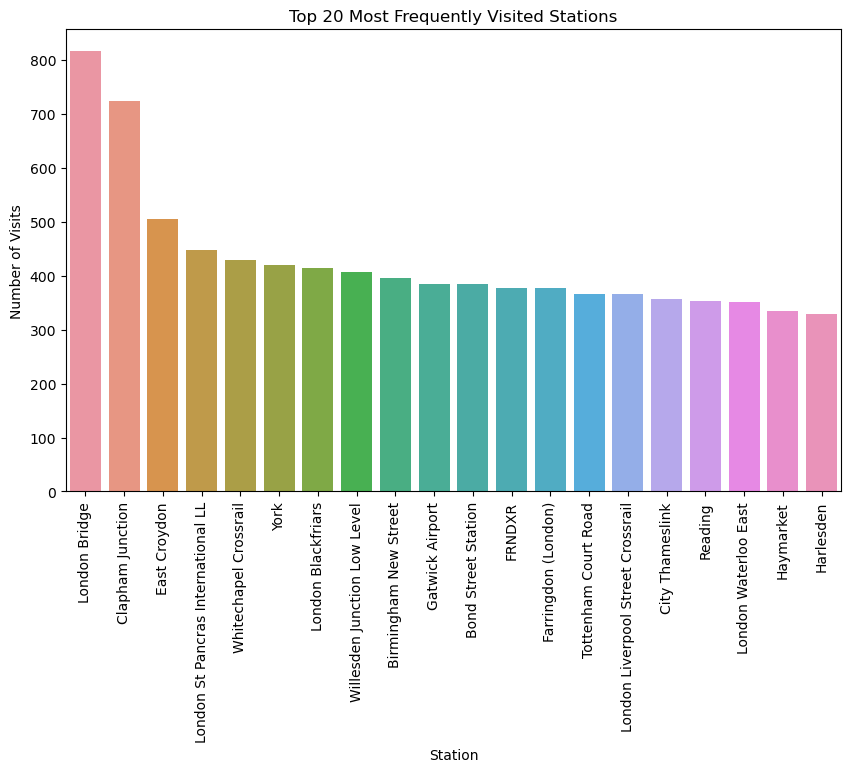

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
# Top 10 most frequently visited stations
top_stations = df_merged['StationName'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stations.index, y=top_stations.values)
plt.title('Top 20 Most Frequently Visited Stations')
plt.xlabel('Station')
plt.ylabel('Number of Visits')
plt.xticks(rotation=90)
plt.show()

In [69]:
df_merged.describe()

,duration (min),Latitude,Longitude
count,119349.000000,113688.000000,113688.000000
mean,1.442733,52.361502,-1.218320
std,3.426250,1.466426,1.498868
min,0.050000,50.148339,-5.839077
25%,0.500000,51.450029,-2.373949
50%,1.000000,51.567944,-0.457724
75%,1.000000,53.372648,-0.086088
max,247.000000,58.513622,1.715711


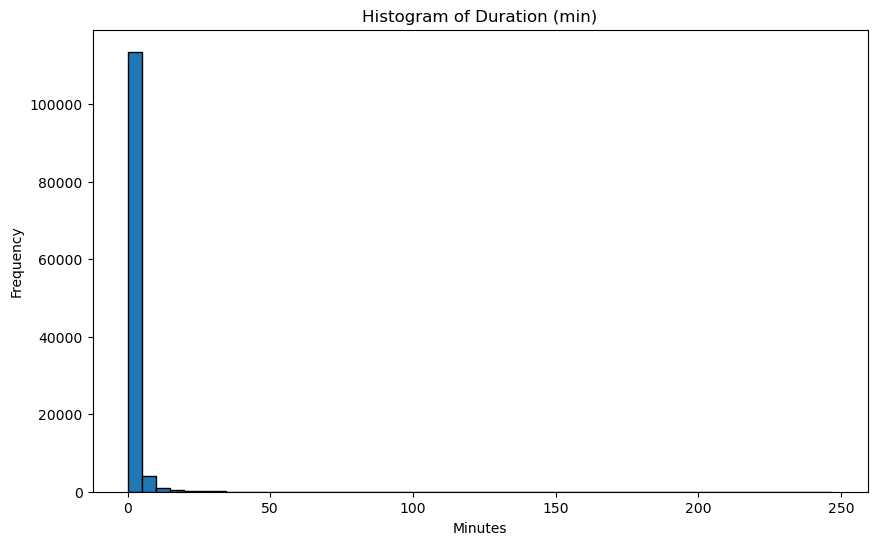

In [70]:
# Histogram for 'duration (min)'
plt.figure(figsize=(10, 6))
plt.hist(df_merged['duration (min)'], bins=50, edgecolor='black')
plt.title('Histogram of Duration (min)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

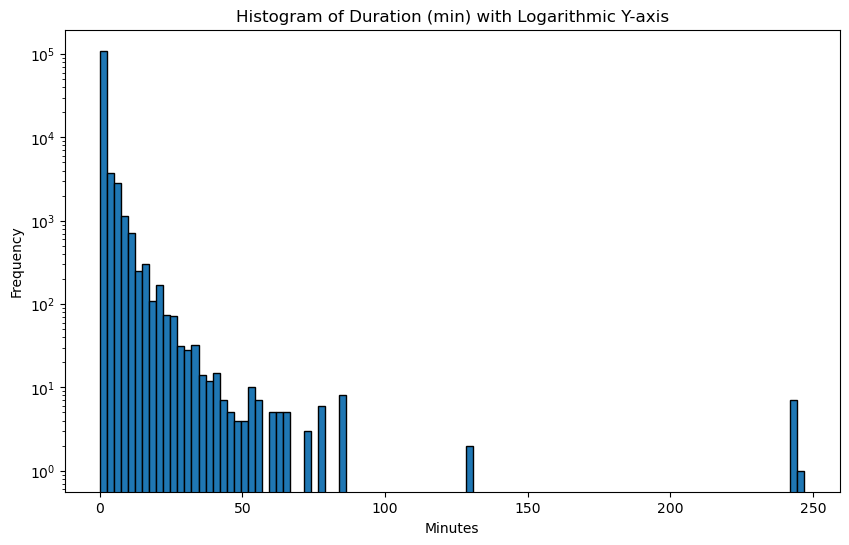

In [71]:
# Histogram for 'duration (min)' with smaller bins and logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.hist(df_merged['duration (min)'], bins=100, edgecolor='black', log=True)

plt.title('Histogram of Duration (min) with Logarithmic Y-axis')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

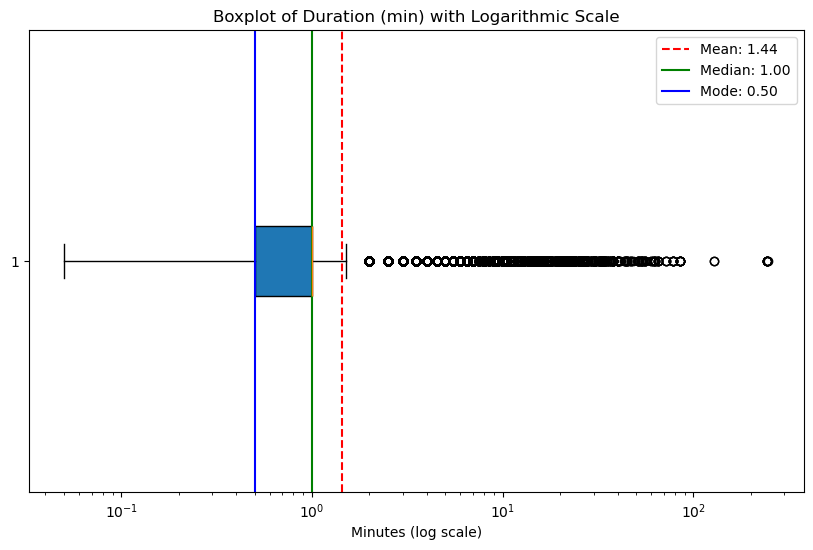

In [72]:
# Boxplot for 'duration (min)' with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.boxplot(df_merged['duration (min)'], vert=False, patch_artist=True, showfliers=True)
plt.xscale('log')

# Add mean and median lines
mean_duration = df_merged['duration (min)'].mean()
median_duration = df_merged['duration (min)'].median()
mode_duration = df_merged['duration (min)'].mode().iloc[0]

plt.axvline(mean_duration, color='r', linestyle='--', label=f'Mean: {mean_duration:.2f}')
plt.axvline(median_duration, color='g', linestyle='-', label=f'Median: {median_duration:.2f}')
plt.axvline(mode_duration, color='b', linestyle='-', label=f'Mode: {mode_duration:.2f}')

plt.title('Boxplot of Duration (min) with Logarithmic Scale')
plt.xlabel('Minutes (log scale)')
plt.legend()
plt.show()

# Export Desired Dataframe

In [73]:
output = df_merged.to_csv('./cleaned_data/UK_Rail_Data.csv', index=False, mode = 'w+')